### Testing META's lag-llama on stock market forecasting. 

We want to test META's lag-llama on stock market forecasting. We first try zero-forecasting and then fine tune the model on the data. Zero-shot forecasting is not that accurate, however, with even a small fine-tuning accuracy is very much improved. For the stock market data we use the online available data of Yahoo finance, and for the model's weights we use Hugginface's repository.

This is the first step towards applying this model to a broader set of time-series.




#### 1. Import packages, define path to model and estimator arguments 
The version requirements are detailed in the requirements.txt file to ensure compatibility with each other. I choose to suppress warnings here, but these lines should be commented out if warnings are to be kept. 

In [35]:
import pandas as pd
import json
import torch
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import tqdm
import yfinance as yf

from itertools import islice
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.common import ListDataset
from gluonts.dataset.repository.datasets import get_dataset,dataset_names
from gluonts.dataset.util import to_pandas
from lag_llama.gluon.estimator import LagLlamaEstimator
from sklearn.metrics import mean_absolute_error

# Suppress warnings 
import warnings
warnings.filterwarnings("ignore")

# path to the weights of the model 
path_model = "/home/saltas/lag-llama/lag-llama.ckpt"
# load the weights of the model 
ckpt = torch.load(path_model, map_location=torch.device('cuda:0'))
# Parameters for the lag-llama estimator. The can be tuned later 
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]


#### 2. Define necessary functions
We define functions which we will later use for stock data downloading from yahoo finance, data preparation, zero-shot forecasting with lag-llama, model fine-tuning, plotting the results etc.

In [33]:
# Download the stock data form yahoo finance. 
# Returns a Pandas dataframe with the stock data. When normalisation == True, the 
# Stock values are normalised for better analysis. 
def download_stock_data(stock_name, normalise = True):    
    stock_data = ( yf.Ticker(stock_name)
                  .history(period="max", start="2024-01-01")
                  .Close
                  .resample('1d')
                  .ffill() ) 
    stock_data = pd.DataFrame(stock_data)
    stock_data = stock_data['Close']
    stock_data = pd.DataFrame(stock_data)
    if normalise == True: # normalise between 0-1 if needed. It is always a good idea.
        stock_data = pd.DataFrame(stock_data)       
        stock_data = stock_data.rolling(5).mean().pct_change().dropna()
    return stock_data

# Prepare the dataset for efficient use with lag-llama.
# Returns a panda dataset dictionary
def prepare_dataset(dataset):
    dataset = dataset.copy()
    for col in dataset.columns:
        if dataset[col].dtype != "object" and not pd.api.types.is_string_dtype(dataset[col]):
            dataset[col] = dataset[col].astype("float32")
    return PandasDataset(dict(dataset))

# Performs zero-forecasting with the lag-llama estimator. 
# Returns arrays with the actual and forecasted values. 
# Lag-llama forecasting estimator. Returns arrays with the actual and forecasted values. 
def future_forecast(dataset, model_ckpt, prediction_length, context_length,
             num_samples, device="cuda", batch_size=1, path_model = path_model):

    ckpt = torch.load(path_model, map_location=torch.device('cuda:0')) # load the lag-llama model
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"] # hyper-parameters 
    
    if context_length == None:
      context_length=estimator_args['context_length']

    # The lag-llama estimator. 
    estimator = LagLlamaEstimator(
        ckpt_path = path_model,
        context_length=context_length,
        prediction_length=prediction_length,

        ###### HYPERPARAMETERS  ######
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        num_parallel_samples=num_samples,
        ###############################
        rope_scaling={
              "type": "linear",
              "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
          },
        
        batch_size=batch_size,
    )
   
    lightning_module = estimator.create_lightning_module().to(device)
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    # Use the gluonts's 'make_evaluation_predictions' functionality to make the forecast
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

# This is the function which fine-tunes the model, through the estimator.train functionality.
# It is important to set the learning rate and max_epochs appropriately for a satisfactory fine tuning.
# Returns values for the x- and y- axis for the fine-tuned forecasting.
# The number of samples needs to be suficiently high for accurate statistical representation. 
def fine_tune(dataset, ckpt_path, prediction_length, context_length, learning_rate, max_epochs):
    ckpt = torch.load(ckpt_path, map_location=torch.device('cuda:0'))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path=path_model,
        prediction_length=prediction_length, #prediction_length,
        context_length=context_length, #context_length,
        aug_prob=0,
        lr=learning_rate, 

        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        batch_size=64,
        num_parallel_samples=100,
        trainer_kwargs = {"max_epochs": max_epochs,}, # <- lightning trainer arguments
        )
    print("Fine tuning with:", "learning rate = ", learning_rate, " || ", "epochs = ", max_epochs )
    predictor_fine_tuned = estimator.train(dataset, cache_data=True, shuffle_buffer_length=1000)
    
    return predictor_fine_tuned

# This plots the results given the values for the x- and y-axis produced by the forecasting functions.
def plot_forecast(time_axis, y_values):
    plt.figure(figsize=(20, 15))
    # Plot the results: Actual vs Predicted  
    plt.figure(figsize=(20, 15))
    date_formater = mdates.DateFormatter('%b, %d')
    plt.rcParams.update({'font.size': 15})
    
    for idx, (y_values, time_axis) in islice(enumerate(zip(y_values, time_axis)), 9):
        ax = plt.subplot(3, 3, idx+1)
    
        plt.plot(time_axis[-4 * prediction_length:].to_timestamp(), label=stock_name, )
        y_values.plot( color='r', )
        plt.xticks(rotation=90)
        ax.xaxis.set_major_formatter(date_formater)
        ax.set_title(stock_name)


#### 3. Make zero-shot predictions for specific stocks

We start with zero-shot forecasting, that is, using the pre-trained lag-llama model without fine-tuning. The performance is not too bad, although it can be highly improved with fine tuning. One needs to make sure that the prediction and context lengths are chosen appropriately.

<Figure size 2000x1500 with 0 Axes>

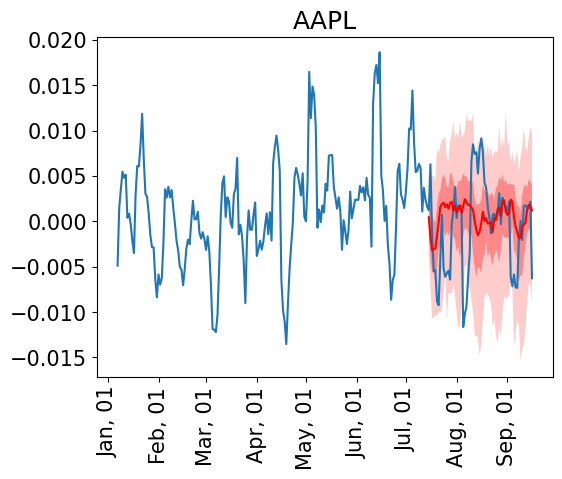

In [30]:
# Define the stock's name and the future time-frame to forecast
stock_name = 'AAPL'
prediction_length = 64
context_length = 32
num_samples = 100

# Download the stock's data from yahoo finance 
stock_data = download_stock_data(stock_name, normalise = True)

# Prepare and normalise the dataset 
dataset = prepare_dataset(dataset = stock_data)

# Do forecasting with lag-llama. Prediction length and context length must be varies for optimal results. 
# num_samples defines the statistical realisations of the prediction to output.
# Arguments: dataset, path_model = path_model, prediction_length = 24, context_length=32, 
#num_samples=100, device="cuda", batch_size=1
forecasts, tss = future_forecast(dataset, ckpt, 
                prediction_length= 64, context_length=32, num_samples=100,
                device=torch.device('cuda') )

# plot the  results
plot_forecast(tss, forecasts)

#### Fine tuning lag-llama [in progress]

We fine tunes the lag-llaa model on the given dataset for more accurate forecasting, compared to the zero-shot case. 

We start by keeping the prediction and context lengths constants, but later we plan to vary them too, towards an optimal fine tuning. In principle, all meaningful hyper-parameters need be varied to find the optimal fine-tuning. 

Turns out that an order $\sim 10$ epochs of training is enough for lag-llama to give good results for the datasets we tried. 




Fine tuning with: learning rate =  0.1  ||  epochs =  10


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached -0.76755 (best -0.76755), saving model to '/home/saltas/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached -1.09335 (best -1.09335), saving model to '/home/saltas/lightning_logs/version_37/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached -2.73527 (best -2.73527), saving model to '/home/saltas/lightning_logs/version_37/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached -3.70869 (best -3.70869), saving model to '/home/saltas/lightning_logs/version_37/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached -3.72142 (best -3.72142), saving model to '/home/saltas/lightning_logs/version_37/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached -3.73660 (best -3.73660), saving model to '/home/saltas/lightning_logs/version_37/checkpoi

<Figure size 2000x1500 with 0 Axes>

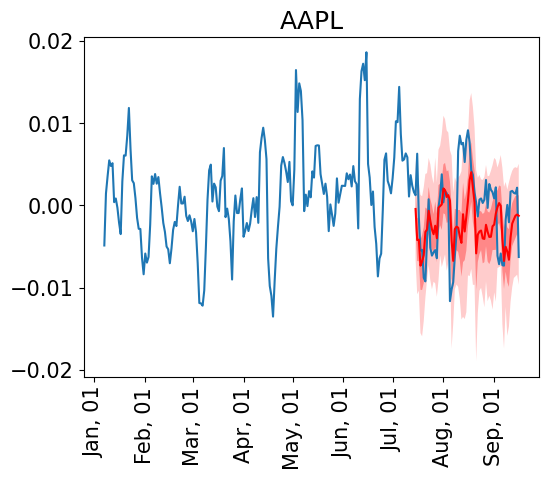

In [34]:

# Train the fine tuned model using the same prediction length and context length
# with the zero-shot forecasting. This can be of course changed if needed in the arguments

predictor_fine_tuned = fine_tune(dataset = dataset, ckpt_path = path_model, prediction_length = prediction_length, context_length = 32, learning_rate = 10e-2, max_epochs = 10)

# produce prediction with fine-tundes model 
forecast_it, ts_it = make_evaluation_predictions(
                     dataset=dataset, predictor=predictor_fine_tuned, num_samples=500 )


# plot the fine-tuned results
plot_forecast(ts_it, forecast_it)

#######

